In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import argparse
import os
from collections import defaultdict

import torch

from habitat.config import Config as CN
from habitat.utils.visualizations.utils import images_to_video, observations_to_image

from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class, NavRLEnv
from habitat_baselines.config.default import get_config
from habitat_baselines.utils.common import batch_obs, generate_video
from habitat_baselines.utils.env_utils import construct_envs

import inspect
import path_utils
path_utils.add_path_to_sys_path("../python", mode="relative_to_cwd", frame=inspect.currentframe())

from my_habitat_baselines.resnet_policy import PointNavResNetPolicy

In [3]:
jupyter_dir = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter"

jupyter_dir

'/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter'

In [6]:
#
# specify args
#

model_path = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models"

arg_string = ""

arg_string += "--model-path %s" % model_path

arg_string += \
"""
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000
"""

# arg_string += \
# """
# --sensors DEPTH_SENSOR
# --hidden-size 512
# --normalize-visual-inputs 0
# --backbone resnet50
# --num-recurrent-layers 2
# TEST_EPISODE_COUNT 5
# TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
# TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
# TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
# TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
# TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
# TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
# TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
# TASK_CONFIG.DATASET.SPLIT minival
# TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
# TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
# TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
# VIDEO_OPTION ['disk']
# TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000
# """

print(arg_string)

parser = argparse.ArgumentParser()
parser.add_argument("--model-path", type=str, required=True)
parser.add_argument("--sensors", type=str, required=True)
parser.add_argument("--hidden-size", type=int, required=True)
parser.add_argument(
    "--normalize-visual-inputs", type=int, required=True, choices=[0, 1]
)
parser.add_argument(
    "--backbone",
    type=str,
    required=True,
    choices=["resnet50", "se_resneXt50"],
)
parser.add_argument("--num-recurrent-layers", type=int, required=True)
parser.add_argument(
    "opts",
    default=None,
    nargs=argparse.REMAINDER,
    help="Modify config options from command line",
)
args = parser.parse_args(arg_string.split())

print(args)

--model-path /Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000

Namespace(backbone='resnet50', hidden_size=512, model_path='/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models', normalize_visual_inputs=1, num_re

In [7]:
#
# load and customize config
#

habitat_dir = "/Users/mroberts/code/github/habitat-lab"
os.chdir(habitat_dir)

config = get_config(
    "habitat_baselines/config/pointnav/ppo_pointnav.yaml"
)

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL = CN()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = None
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = None
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV = None
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV = None
config.TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY = None
config.freeze()

config.merge_from_list(args.opts)

# config.defrost()
# config.TASK_CONFIG.SIMULATOR.ACTION_SPACE_CONFIG = "pyrobotnoisy"
# config.freeze()

# config.defrost()
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = "ILQR"    # our pre-trained model lists "proportional" in the filename, so don't change to ILQR 
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 1.0 # our pre-trained model lists "0.5" in the filename, so don't change to 1.0
# config.freeze()

# config.defrost()
# config.TASK_CONFIG.SIMULATOR.AGENT_0.SENSORS = ["DEPTH_SENSOR"]
# config.freeze()

config.defrost()
config.TASK_CONFIG.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
config.freeze()

config.defrost()
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ["*"]
config.TASK_CONFIG.DATASET.DATA_PATH = "data/datasets/pointnav/gibson/v2/val/val.json.gz" # don't have obstacle_1 scenes, so use Gibson instead
config.freeze()

config.defrost()
config.NUM_ENVIRONMENTS = 1
config.freeze()

config.defrost()
if args.sensors == "":
    config.SENSORS = []
else:
    config.SENSORS = args.sensors.split(",")
# TODO(akadian): collisions are not working
# config.TASK_CONFIG.TASK.MEASUREMENTS.append("COLLISIONS")
config.freeze()

print(config)

BASE_TASK_CONFIG_PATH: configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: -1
CMD_TRAILING_OPTS: []
ENV_NAME: NavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
FORCE_BLIND_POLICY: False
FORCE_TORCH_SINGLE_THREADED: True
LOG_FILE: train.log
LOG_INTERVAL: 25
NUM_CHECKPOINTS: 100
NUM_ENVIRONMENTS: 1
NUM_PROCESSES: -1
NUM_UPDATES: 10000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
PROFILING:
  CAPTURE_START_STEP: -1
  NUM_STEPS_TO_CAPT

In [8]:
#
# construct a single env instead of multiple envs for simplicity
#

env = NavRLEnv(config)

2021-11-23 19:36:11,695 Initializing dataset PointNav-v1
2021-11-23 19:36:11,715 initializing sim Sim-v0
I1123 19:36:11.717487 442027456 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1123 19:36:15.400527 67823 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Sands.navmesh
I1123 19:36:11.717515 442027456 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1123 19:36:11.717593 442027456 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1123 19:36:11.717633 442027456 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


In [9]:
#
# create device
#

device = (
    torch.device("cuda:{}".format(config.TORCH_GPU_ID))
    if torch.cuda.is_available()
    else torch.device("cpu")
)

device

device(type='cpu')

In [11]:
#
# load model
#

def load_model(
    path,
    observation_space,
    action_space,
    hidden_size,
    normalize_visual_inputs,
    backbone,
    num_recurrent_layers,
    device,
):

    model = PointNavResNetPolicy(
        observation_space=observation_space,
        action_space=action_space,
        hidden_size=hidden_size,
        normalize_visual_inputs=normalize_visual_inputs,
        backbone=backbone,
        num_recurrent_layers=num_recurrent_layers,
        goal_sensor_uuid="pointgoal_with_gps_compass",
    )

    model.to(device)

    new_model_params = sum(
        [torch.numel(p) for _, p in model.named_parameters()]
    )

    saved_model = torch.load(path, map_location=device)
    saved_model_params = sum(
        [torch.numel(v) for k, v in saved_model["state_dict"].items()]
    )

    print(
        "new_model_params: {}, saved_model_params: {}".format(
            new_model_params, saved_model_params
        )
    )

    saved_model_state_dict = {}
    for k, v in saved_model["state_dict"].items():
        new_k = k.replace("actor_critic.", "")
        saved_model_state_dict[new_k] = v

    model.load_state_dict(saved_model_state_dict)

    return model



model_path = \
"/Users/mroberts/code/github/interiorsim/code/experiments/srcc/models/" + \
"job_19633792"                        + "." \
"sensor_RGB_SENSOR"                   + "." \
"train_data_gibson"                   + "." \
"noise_multiplier_0.5"                + "." \
"noise_model_controller_Proportional" + "." \
"agent_radius_0.20"                   + "." \
"success_reward_10.0"                 + "." \
"slack_reward_-0.01"                  + "." \
"collision_reward_0.0"                + "." \
"spl_max_collisions_500"              + "_" \
"ckpt.000000049"                      + \
".pth"
print(model_path)

# model_path = \
# "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/models/" + \
# "job_19633798"                        + "." \
# "sensor_DEPTH_SENSOR"                 + "." \
# "train_data_gibson"                   + "." \
# "noise_multiplier_0.5"                + "." \
# "noise_model_controller_Proportional" + "." \
# "agent_radius_0.20"                   + "." \
# "success_reward_10.0"                 + "." \
# "slack_reward_-0.01"                  + "." \
# "collision_reward_0.0"                + "." \
# "spl_max_collisions_500"              + "_" \
# "ckpt.000000059"                      + \
# ".pth"
# print(model_path)

action_space = env.action_space
observation_space = env.observation_space

model = load_model(
    path=model_path,
    observation_space=observation_space,
    action_space=action_space,
    hidden_size=args.hidden_size,
    normalize_visual_inputs=bool(args.normalize_visual_inputs),
    backbone=args.backbone,
    num_recurrent_layers=args.num_recurrent_layers,
    device=device,
)

model.eval()

model_params = 0
for k,v in model.state_dict().items():
    # print(k, torch.numel(v))
    model_params += torch.numel(v)
print(model_params)

saved_model = torch.load(model_path, map_location=device)

saved_model_params = 0
for k,v in saved_model["state_dict"].items():
    # print(k, torch.numel(v))
    saved_model_params += torch.numel(v)
print(saved_model_params)

/Users/mroberts/code/github/interiorsim/code/experiments/srcc/models/job_19633792.sensor_RGB_SENSOR.train_data_gibson.noise_multiplier_0.5.noise_model_controller_Proportional.agent_radius_0.20.success_reward_10.0.slack_reward_-0.01.collision_reward_0.0.spl_max_collisions_500_ckpt.000000049.pth
new_model_params: 12458053, saved_model_params: 12458060
12458060
12458060


In [13]:
import gym.spaces.dict

observation_space_ = \
    gym.spaces.Dict({"rgb": gym.spaces.Box(low=0, high=255, shape=(256,256,3), dtype=np.uint8),
                     "pointgoal_with_gps_compass": gym.spaces.Box(
                         low=observation_space["pointgoal_with_gps_compass"].low,
                         high=observation_space["pointgoal_with_gps_compass"].high,
                         shape=observation_space["pointgoal_with_gps_compass"].shape,
                         dtype=observation_space["pointgoal_with_gps_compass"].dtype)})

# observation_space_ = \
#     gym.spaces.Dict({"depth": gym.spaces.Box(low=0.0, high=1.0, shape=(256,256,1), dtype=np.float32),
#                      "pointgoal_with_gps_compass": gym.spaces.Box(
#                          low=observation_space["pointgoal_with_gps_compass"].low,
#                          high=observation_space["pointgoal_with_gps_compass"].high,
#                          shape=observation_space["pointgoal_with_gps_compass"].shape,
#                          dtype=observation_space["pointgoal_with_gps_compass"].dtype)})

print(observation_space_ == observation_space)

print(observation_space)
print()

print(observation_space_)
print()

True
Dict(pointgoal_with_gps_compass:Box([-3.4028235e+38 -3.4028235e+38], [3.4028235e+38 3.4028235e+38], (2,), float32), rgb:Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  

DISTANCE_TO_GOAL
DISTANCE_TO: POINT
TYPE: DistanceToGoal
<class 'habitat.tasks.nav.nav.DistanceToGoal'>
distance_to_goal

994

NavigationEpisode(episode_id='11', scene_id='data/scene_datasets/gibson/Sands.glb', start_position=[3.198387861251831, 1.5990136861801147, 0.49142053723335266], start_rotation=[0, 0.912534060483753, 0, -0.4090007193844947], info={'geodesic_distance': 4.263117790222168}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fd161595b30>, goals=[NavigationGoal(position=[-0.2237996757030487, 1.5990136861801147, -1.2859920263290405], radius=0.2)], start_room=None, shortest_paths=None)

{'distance_to_goal': 4.263117790222168, 'success': 0.0, 'spl': 0.0}

tensor([[0.]])
(256, 256, 3)


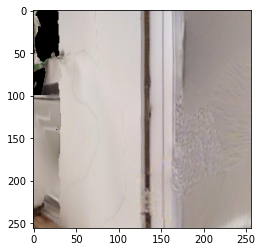

In [14]:
#
# initialization before main loop
#

metric_name = config.TASK_CONFIG.TASK.MEASUREMENTS[0]
metric_cfg = getattr(config.TASK_CONFIG.TASK, metric_name)
measure_type = baseline_registry.get_measure(metric_cfg.TYPE)
metric_uuid = measure_type(None, None)._get_uuid()

assert measure_type is not None, "invalid measurement type {}".format(metric_cfg.TYPE)

print(metric_name)
print(metric_cfg)
print(measure_type)
print(metric_uuid)
print()

observation = env.reset()

print(len(env.episodes))
print()

print(env.current_episode)
print()

print(env._env.get_metrics())
print()

observations = [observation]
batch = batch_obs(observations, device)

num_processes = 1

test_recurrent_hidden_states = torch.zeros(
    model.net.num_recurrent_layers,
    num_processes,
    args.hidden_size,
    device=device,
)
prev_actions = torch.zeros(
    num_processes, 1, device=device, dtype=torch.long
)
not_done_masks = torch.zeros(num_processes, 1, device=device)
print(not_done_masks)

current_episode_num_actions = 0
current_episode_reward = 0.0
current_episode_stats_actions = defaultdict(int)

stats_episodes = dict()  # dict of dicts that stores stats per episode

print(observation["rgb"].shape)
# print(observation["depth"].shape)

figsize(4,4)
imshow(observation["rgb"]);
# imshow(observation["depth"]);
# colorbar();

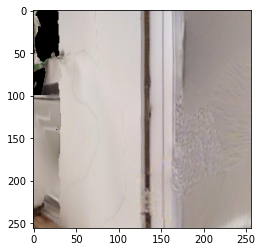

In [15]:
imshow(observation["rgb"]);
# imshow(observation["depth"]);
# colorbar();

In [18]:
print(observation["rgb"])

[[[173 162 158]
  [172 161 157]
  [172 161 155]
  ...
  [215 194 173]
  [215 194 173]
  [214 194 173]]

 [[173 162 158]
  [173 162 158]
  [173 163 155]
  ...
  [215 194 173]
  [215 194 173]
  [214 194 173]]

 [[173 162 158]
  [173 162 158]
  [173 163 155]
  ...
  [215 194 173]
  [215 194 173]
  [214 194 173]]

 ...

 [[149 123  92]
  [151 125  94]
  [153 127  96]
  ...
  [211 192 177]
  [211 192 177]
  [211 192 177]]

 [[146 119  89]
  [149 122  92]
  [152 125  96]
  ...
  [211 192 177]
  [211 192 177]
  [211 192 177]]

 [[152 125  95]
  [152 125  94]
  [152 124  92]
  ...
  [211 192 177]
  [211 192 177]
  [211 192 177]]]


In [19]:
max_num_actions_per_episode = 10000
num_episodes = 994

while len(stats_episodes) < num_episodes:

    #
    # main loop: choose action
    #

    with torch.no_grad():
        _, actions, _, test_recurrent_hidden_states = model.act(
            batch,
            test_recurrent_hidden_states,
            prev_actions,
            not_done_masks,
            deterministic=False,
        )

        prev_actions.copy_(actions)

    assert len(actions) == 1
    action = actions[0]
    
    print(env.habitat_env.task.get_action_name(action.item()))

    #
    # main loop: perform action
    #

    observation, reward, done, info = env.step(action=action.item())

    #
    # main loop: update state
    #

    observations = [observation]
    batch = batch_obs(observations, device)

    print(batch["rgb"].shape)
    print(batch["rgb"])
    print()

    # print(batch["depth"].shape)
    # print()
    
    assert False
    
    dones = [done]
    not_done_masks = torch.tensor(
        [[0.0] if done else [1.0] for done in dones],
        dtype=torch.float,
        device=device,
    )

    current_episode_num_actions += 1
    current_episode_reward += reward
    current_episode_stats_actions[action.item()] += 1
    
    assert current_episode_num_actions < max_num_actions_per_episode
    
    if done:
        
        # record stats
        stats_episode = dict(info)
        stats_episode["reward"] = current_episode_reward
        stats_episode["stats_actions"] = dict(current_episode_stats_actions)
        
        # if len(stats_episodes) % 100 == 0:
        #     print("Episodes finished: {}".format(len(stats_episodes)))

        print("Episodes finished: {}".format(len(stats_episodes)))

        stats_episodes[ (env.current_episode.scene_id, env.current_episode.episode_id) ] = stats_episode
            
        # reset env
        observation = env.reset()
        observations = [observation]
        batch = batch_obs(observations, device)

        test_recurrent_hidden_states = torch.zeros(
            model.net.num_recurrent_layers,
            num_processes,
            args.hidden_size,
            device=device,
        )
        prev_actions = torch.zeros(
            num_processes, 1, device=device, dtype=torch.long
        )
        not_done_masks = torch.zeros(num_processes, 1, device=device)

        current_episode_num_actions = 0
        current_episode_reward = 0.0
        current_episode_stats_actions = defaultdict(int)

MOVE_FORWARD
torch.Size([1, 256, 256, 3])
tensor([[[[174, 163, 159],
          [174, 163, 159],
          [175, 164, 158],
          ...,
          [183, 166, 148],
          [181, 164, 146],
          [182, 165, 147]],

         [[175, 164, 158],
          [174, 163, 156],
          [175, 165, 157],
          ...,
          [183, 166, 148],
          [182, 165, 147],
          [182, 165, 147]],

         [[175, 164, 159],
          [174, 163, 157],
          [175, 164, 157],
          ...,
          [182, 165, 147],
          [181, 164, 147],
          [182, 165, 149]],

         ...,

         [[155, 128, 100],
          [157, 131, 102],
          [159, 133, 103],
          ...,
          [142, 118,  89],
          [148, 125,  94],
          [155, 131,  98]],

         [[156, 129, 100],
          [158, 131, 102],
          [159, 134, 104],
          ...,
          [140, 115,  80],
          [146, 119,  82],
          [149, 122,  79]],

         [[150, 123,  94],
          [155, 128, 

AssertionError: 

In [11]:
valid = np.array([ np.isfinite(s[1]["distance_to_goal"]) for s in stats_episodes.items() ])

print(np.count_nonzero(valid) / valid.shape[0])
print(np.count_nonzero(valid))
print(valid.shape[0])

success = np.array([ s[1]["success"] for s in stats_episodes.items() ])
spl = np.array([ s[1]["spl"] for s in stats_episodes.items() ])

success = success[valid]
spl = spl[valid]

print(np.mean(success))
print(np.mean(spl))

0.9688128772635815
963
994
0.9273104880581516
0.67534450692932


In [12]:
stats_episodes

{('data/scene_datasets/gibson/Sands.glb',
  '11'): {'distance_to_goal': 0.10046201944351196, 'success': 1.0, 'spl': 0.6272533396998001, 'reward': 6.15265577077866, 'stats_actions': {3: 14,
   1: 29,
   2: 7,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '8'): {'distance_to_goal': 6.908705711364746, 'success': 0.0, 'spl': 0.0, 'reward': -0.09587873458862302, 'stats_actions': {3: 12,
   1: 1,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '46'): {'distance_to_goal': 0.13226138055324554, 'success': 1.0, 'spl': 0.6960699973885071, 'reward': 6.6568112283945124, 'stats_actions': {1: 27,
   2: 2,
   3: 10,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '52'): {'distance_to_goal': 0.06308531016111374, 'success': 1.0, 'spl': 0.6929840384519903, 'reward': 4.29586676388979, 'stats_actions': {1: 12,
   3: 8,
   2: 1,
   0: 1}},
 ('data/scene_datasets/gibson/Sands.glb',
  '57'): {'distance_to_goal': 0.10238044708967209, 'success': 1.0, 'spl': 0.7942065061551548, 'reward': 8

In [20]:
import pickle

pickle_file = os.path.join(jupyter_dir, "..", "data", "habitat_gibson_val_challenge_sim_predicted_depth_train_sliding_on_train_noise_multiplier_0.0.pickle")

print("Loading from: " + pickle_file)
print()

with open(pickle_file, "rb") as p:
    stats_episodes = pickle.load(p)

print("Finished.")
print()

Loading from: /Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/../data/habitat_gibson_val_challenge_sim_predicted_depth_train_sliding_on_train_noise_multiplier_0.0.pickle

Finished.



In [21]:
valid = np.array([ np.isfinite(s[1]["distance_to_goal"]) for s in stats_episodes.items() ])

print(np.count_nonzero(valid) / valid.shape[0])
print(np.count_nonzero(valid))
print(valid.shape[0])
    
success = np.array([ s[1]["success"] for s in stats_episodes.items() ])
spl = np.array([ s[1]["spl"] for s in stats_episodes.items() ])

success = success[valid]
spl = spl[valid]

print(np.mean(success))
print(np.mean(spl))

0.9688128772635815
963
994
0.8078920041536864
0.5453894424228085
